In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import HuberRegressor, LinearRegression
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import joblib
from datetime import datetime as dt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving balancing.xlsx to balancing (2).xlsx
Saving crossborder.xlsx to crossborder (2).xlsx
Saving demand_forecast (2).csv to demand_forecast (2) (2).csv
Saving generation.csv to generation (2).csv
Saving price.csv to price (2).csv
Saving residual_demand_forecast.csv to residual_demand_forecast (2).csv
Saving risks.csv to risks (2).csv
Saving temp.xlsx to temp (2).xlsx


In [ ]:
temp = pd.read_excel('temp.xlsx')
demand = pd.read_csv('demand_forecast (2).csv')
price = pd.read_csv('price.csv')
generation = pd.read_csv('generation.csv')
risks = pd.read_csv('risks.csv')
crossborder = pd.read_excel('crossborder.xlsx')
balancing = pd.read_excel('balancing.xlsx')
residual_demand = pd.read_csv('residual_demand_forecast.csv')

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
temp

,time,temperature_2m (°C)
0,2025-06-14 00:00:00,20.3
1,2025-06-14 01:00:00,19.4
2,2025-06-14 02:00:00,18.5
3,2025-06-14 03:00:00,18.4
4,2025-06-14 04:00:00,17.9
...,...,...
1147,2025-07-31 19:00:00,26.3
1148,2025-07-31 20:00:00,25.6
1149,2025-07-31 21:00:00,24.8
1150,2025-07-31 22:00:00,24.0


In [ ]:
crossborder

,Időpont,HU-UK,HU-SK,HU-SI,HU-RS,HU-AT,HU-HR,HU-RO,HU-AT menetrend,HU-HR menetrend,HU-SI menetrend (RIR NT),HU-SK menetrend,HU-RS menetrend,HU-UK menetrend,HU-RO menetrend
0,2025.06.15 00:00:00 +0200,209.162,2153.334,46.220,-90.783,705.998,-332.184,-316.402,1788.975,69.500,490.750,1284.425,-399.0,232.0,-1092.500
1,2025.06.15 01:00:00 +0200,69.138,2181.158,17.026,-128.409,657.331,-381.487,-337.399,1136.950,50.850,697.325,1268.675,-159.0,139.0,-1058.100
2,2025.06.15 02:00:00 +0200,102.930,2102.658,4.384,-156.595,495.486,-405.789,-342.563,1171.725,36.850,705.525,872.625,-244.0,174.0,-925.775
3,2025.06.15 03:00:00 +0200,170.590,1976.145,-43.829,-71.251,327.940,-345.708,-327.798,802.600,134.425,553.225,824.900,-140.0,174.0,-706.050
4,2025.06.15 04:00:00 +0200,167.986,1918.514,-47.582,-52.868,322.995,-325.527,-354.750,717.675,148.500,532.575,787.250,-139.0,174.0,-656.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,2025.08.04 21:00:00 +0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1222,2025.08.04 22:00:00 +0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1223,2025.08.04 23:00:00 +0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1224,2025.08.05 00:00:00 +0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
risks

,Date (CET),Demand Upward Risk,Solar Upward Risk,Wind Upward Risk,Demand Downward Risk,Solar Downward Risk,Wind Downward Risk,OUTTURN Deviation
0,NaN,MW,MW,MW,MW,MW,MW,MW
1,[14/06/2025 23:00],0,0,14,-336,0,-18,-140
2,[15/06/2025 00:00],187,0,11,-316,0,-24,-100
3,[15/06/2025 01:00],86,0,11,-380,0,-24,-71
4,[15/06/2025 02:00],69,0,4,-375,0,-20,-42
...,...,...,...,...,...,...,...,...
1221,[04/08/2025 19:00],125,104,26,-370,-19,-83,NaN
1222,[04/08/2025 20:00],138,5,22,-332,0,-98,NaN
1223,[04/08/2025 21:00],131,0,16,-310,0,-106,NaN
1224,[04/08/2025 22:00],128,0,16,-290,0,-93,NaN


In [ ]:
risks.drop(0, inplace=True)

In [ ]:
risks

,Date (CET),Demand Upward Risk,Solar Upward Risk,Wind Upward Risk,Demand Downward Risk,Solar Downward Risk,Wind Downward Risk,OUTTURN Deviation
1,[14/06/2025 23:00],0,0,14,-336,0,-18,-140
2,[15/06/2025 00:00],187,0,11,-316,0,-24,-100
3,[15/06/2025 01:00],86,0,11,-380,0,-24,-71
4,[15/06/2025 02:00],69,0,4,-375,0,-20,-42
5,[15/06/2025 03:00],73,0,5,-371,0,-22,-64
...,...,...,...,...,...,...,...,...
1221,[04/08/2025 19:00],125,104,26,-370,-19,-83,NaN
1222,[04/08/2025 20:00],138,5,22,-332,0,-98,NaN
1223,[04/08/2025 21:00],131,0,16,-310,0,-106,NaN
1224,[04/08/2025 22:00],128,0,16,-290,0,-93,NaN


In [ ]:
crossborder.rename(columns={'Időpont' : 'Date (CET)'}, inplace=True)

In [ ]:
crossborder = crossborder[['Date (CET)', 'HU-AT menetrend',	'HU-HR menetrend',	'HU-SI menetrend (RIR NT)',	'HU-SK menetrend',	'HU-RS menetrend',	'HU-UK menetrend',	'HU-RO menetrend']]

In [ ]:
crossborder.rename(columns = {'HU-AT menetrend' : 'HU-AT forecast',
                    'HU-HR menetrend' : 'HU-CR forecast',
                    'HU-SI menetrend (RIR NT)' : 'HU-SI forecast',
                    'HU-SK menetrend' : 'HU-SK forecast',
                    'HU-RS menetrend' : 'HU-RS forecast',
                    'HU-UK menetrend' : 'HU-UK forecast',
                    'HU-RO menetrend' : 'HU-RO forecast'}, inplace=True)

/tmp/ipython-input-3311694587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossborder.rename(columns = {'HU-AT menetrend' : 'HU-AT forecast',


In [ ]:
temp['time'] = temp['time'].astype(str)

In [ ]:
temp.rename(columns={'time' : 'Date (CET)',
                     'temperature_2m ()' : 'temperature'}, inplace=True)

In [ ]:
temp.reset_index(inplace=True)
temp.drop(columns='index', inplace=True)

In [ ]:
temp

,Date (CET),temperature_2m (°C)
0,2025-06-14 00:00:00,20.3
1,2025-06-14 01:00:00,19.4
2,2025-06-14 02:00:00,18.5
3,2025-06-14 03:00:00,18.4
4,2025-06-14 04:00:00,17.9
...,...,...
1147,2025-07-31 19:00:00,26.3
1148,2025-07-31 20:00:00,25.6
1149,2025-07-31 21:00:00,24.8
1150,2025-07-31 22:00:00,24.0


In [ ]:
temp.dtypes

,0
Date (CET),object
temperature_2m (°C),float64


In [ ]:
temp = temp[['Date (CET)', 'temperature_2m (°C)']]

In [ ]:
temp.rename(columns={'temperature_2m (°C)' : 'temperature'}, inplace=True)

In [ ]:
balancing.drop(columns=['Hazai aFRR (aut.) szab. FEL (15p)', 'Hazai aFRR (aut.) szab. LE (15p)', 'IGCC szabályozás FEL (15p)', 'IGCC szabályozás LE (15p)', 'Nem automatikus szabályozás mértéke fel (balancing)', 'Nem automatikus szabályozás mértéke le (balancing)'], inplace=True)
balancing.rename(columns={'Időpont' : 'Date (CET)',
                          'aFRR (aut.) szab. FEL (15p)' : 'aFRR UP',
                          'aFRR (aut.) szab. LE (15p)': 'aFRR DOWN'}, inplace=True)

In [ ]:
balancing.rename(columns={'Időpont' : 'Date (CET)',
                          'aFRR (Automatikus) szabályozás FEL (15p)' : 'aFRR UP',
                          'aFRR (Automatikus) szabályozás LE (15p)': 'aFRR DOWN'}, inplace=True)

In [ ]:
def clean_date_col(df):
  df['Date (CET)'] = df['Date (CET)'].replace(r'\+.*$', '', regex=True)
  df['Date (CET)'] = df['Date (CET)'].str.replace('[', '', regex=False)
  df['Date (CET)'] = df['Date (CET)'].str.replace(']', '', regex=False)
  df['Date (CET)'] = df['Date (CET)'].str.replace('/', '-', regex=False)
  return df

In [ ]:
clean_date_col(generation)
clean_date_col(demand)
clean_date_col(price)
clean_date_col(temp)
clean_date_col(risks)
clean_date_col(crossborder)
clean_date_col(balancing)
clean_date_col(residual_demand)

/tmp/ipython-input-954107501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date (CET)'] = df['Date (CET)'].replace(r'\+.*$', '', regex=True)
/tmp/ipython-input-954107501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date (CET)'] = df['Date (CET)'].str.replace('[', '', regex=False)
/tmp/ipython-input-954107501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,Date (CET),RESIDUAL DEMAND,RESIDUAL DEMAND FORECAST (ENTSOE),RESIDUAL DEMAND FORECAST (ENAPPSYS),RESIDUAL DEMAND FORECAST D-1 (ENAPPSYS),DEMAND FORECAST P10 (ENAPPSYS),DEMAND FORECAST P90 (ENAPPSYS),DEMAND FORECAST UNADJUSTED (ENAPPSYS)
0,NaN,MW,MW,MW,MW,MW,MW,MW
1,14-06-2025 23:00,4404,4182,4431,4491,4159,4480,4358
2,15-06-2025 00:00,4062,3849,4064,4081,3791,4329,4071
3,15-06-2025 01:00,3788,3580,3784,3774,3420,3922,3689
4,15-06-2025 02:00,3670,3424,3671,3628,3295,3764,3558
...,...,...,...,...,...,...,...,...
1221,04-08-2025 19:00,NaN,4683,4702,4716,4280,5006,4716
1222,04-08-2025 20:00,NaN,4971,4873,4882,4534,5129,4882
1223,04-08-2025 21:00,NaN,4839,4814,4838,4506,5069,4838
1224,04-08-2025 22:00,NaN,4552,4600,4590,4273,4800,4590


In [ ]:
print(len(generation), len(demand), len(price), len(temp), len(risks), len(crossborder), len(residual_demand), len(balancing))

1226 1226 1225 1152 1225 1226 1226 1226


In [ ]:
max(temp['temperature'])

38.3

In [ ]:
residual_demand.drop(0, inplace=True)
balancing.drop(0, inplace=True)
crossborder.drop(0, inplace=True)

/tmp/ipython-input-1727747291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossborder.drop(0, inplace=True)


In [ ]:
temp = temp[['Date (CET)', 'temperature']]

In [ ]:
generation.drop(0, inplace=True)
demand.drop(0, inplace=True)

In [ ]:
price.drop(0, inplace=True)

KeyError: '[0] not found in axis'

In [ ]:
price

,Date (CET),LATEST HR PRICE,QH WAP,HR WAP,RPD WAP,DAY AHEAD PRICE,SYSTEM PRICE (POSITIVE),SYSTEM PRICE (NEGATIVE),SYSTEM PRICE (CALCULATED),QH VOLUME,HR VOLUME
1,2025-06-14 23:00:00,120.01,155.32,152.10,154.69,112.08,0.00,-7.14,55.38,207.4,477.0
2,2025-06-15 00:00:00,115.24,114.67,106.16,109.32,92.06,0.00,0.00,46.42,144.8,299.8
3,2025-06-15 01:00:00,100.01,103.66,96.67,98.86,87.92,0.00,0.00,66.51,145.4,352.1
4,2025-06-15 02:00:00,88.91,92.83,90.80,91.34,86.24,107.70,0.00,86.98,103.1,245.9
5,2025-06-15 03:00:00,86.18,96.48,89.24,90.36,88.33,113.26,0.00,109.18,76.7,311.6
...,...,...,...,...,...,...,...,...,...,...,...
1220,2025-08-04 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1221,2025-08-04 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1222,2025-08-04 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1223,2025-08-04 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
generation_col_list = list(generation.columns)
demand_col_list = list(demand.columns)
price_col_list = list(price.columns)
temp_col_list = list(temp.columns)
risks_col_list = list(risks.columns)
crossborder_col_list = list(crossborder.columns)
balancing_col_list = list(balancing.columns)
residual_demand_col_list = list(residual_demand.columns)

def set_datatypes(df, columns_list):
  df[columns_list[0]] = pd.to_datetime(df[columns_list[0]], dayfirst=True)
  for i, col in enumerate(columns_list[1:], start=1):
    df[columns_list[i]] = df[columns_list[i]].astype(float)
  print(df.dtypes)
set_datatypes(generation, generation_col_list)
set_datatypes(demand, demand_col_list)
set_datatypes(price, price_col_list)
set_datatypes(temp, temp_col_list)
set_datatypes(risks, risks_col_list)
set_datatypes(crossborder, crossborder_col_list)
set_datatypes(balancing, balancing_col_list)
set_datatypes(residual_demand, residual_demand_col_list)

Date (CET)                  datetime64[ns]
OIL FORECAST                       float64
LIGNITE FORECAST                   float64
HARD COAL FORECAST                 float64
GAS FORECAST                       float64
HYDRO RESERVOIR FORECAST           float64
HYDRO RIVER FORECAST               float64
SOLAR FORECAST                     float64
WIND FORECAST                      float64
BIOMASS FORECAST                   float64
WASTE FORECAST                     float64
GEOTHERMAL FORECAST                float64
OTHER FORECAST                     float64
NUCLEAR FORECAST                   float64
OIL                                float64
LIGNITE                            float64
HARD COAL                          float64
GAS                                float64
HYDRO RESERVOIR                    float64
HYDRO RIVER                        float64
SOLAR                              float64
WIND                               float64
BIOMASS                            float64
WASTE      

/tmp/ipython-input-700024131.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[columns_list[0]] = pd.to_datetime(df[columns_list[0]], dayfirst=True)
/tmp/ipython-input-700024131.py:11: UserWarning: Parsing dates in %Y.%m.%d %H:%M:%S  format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[columns_list[0]] = pd.to_datetime(df[columns_list[0]], dayfirst=True)
/tmp/ipython-input-700024131.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_list[0]] = pd.to_datetime(df[columns_list[0]], dayfirst=True)
/tmp/ipython-input-700024131.py:13: SettingWithCopyWarning: 
A val

In [ ]:
generation['hour'] = generation['Date (CET)'].dt.hour
demand['hour'] = demand['Date (CET)'].dt.hour
price['hour'] = price['Date (CET)'].dt.hour
temp['hour'] = temp['Date (CET)'].dt.hour
risks['hour'] = risks['Date (CET)'].dt.hour
crossborder['hour'] = crossborder['Date (CET)'].dt.hour
balancing['hour'] = balancing['Date (CET)'].dt.hour
residual_demand['hour'] = residual_demand['Date (CET)'].dt.hour

/tmp/ipython-input-2605978590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossborder['hour'] = crossborder['Date (CET)'].dt.hour


In [ ]:
temp['Date (CET)'] = temp['Date (CET)'].dt.round('H')

/tmp/ipython-input-1470485449.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp['Date (CET)'] = temp['Date (CET)'].dt.round('H')


In [ ]:
print(generation.columns)
print(demand.columns)
print(price.columns)
print(temp.columns)
print(risks.columns)
print(crossborder.columns)
print(balancing.columns)
print(residual_demand.columns)

Index(['Date (CET)', 'OIL FORECAST', 'LIGNITE FORECAST', 'HARD COAL FORECAST',
       'GAS FORECAST', 'HYDRO RESERVOIR FORECAST', 'HYDRO RIVER FORECAST',
       'SOLAR FORECAST', 'WIND FORECAST', 'BIOMASS FORECAST', 'WASTE FORECAST',
       'GEOTHERMAL FORECAST', 'OTHER FORECAST', 'NUCLEAR FORECAST', 'OIL',
       'LIGNITE', 'HARD COAL', 'GAS', 'HYDRO RESERVOIR', 'HYDRO RIVER',
       'SOLAR', 'WIND', 'BIOMASS', 'WASTE', 'GEOTHERMAL', 'OTHER', 'NUCLEAR',
       'DEMAND', 'DEMAND FORECAST', 'hour'],
      dtype='object')
Index(['Date (CET)', 'ACTUAL TOTAL LOAD', 'DEMAND FORECAST', 'BIOMASS',
       'GEOTHERMAL', 'HYDRO (RESERVOIR)', 'HYDRO (RIVER)', 'NUCLEAR',
       'OTHER RENEWABLE', 'SOLAR', 'WASTE', 'WIND - ONSHORE',
       'NUCLEAR AVAILABLITY', 'SOLAR FORECAST', 'WIND ONSHORE FORECAST',
       'DEMAND FORECAST (ENAPPSYS)', 'hour'],
      dtype='object')
Index(['Date (CET)', 'LATEST HR PRICE', 'QH WAP', 'HR WAP', 'RPD WAP',
       'DAY AHEAD PRICE', 'SYSTEM PRICE (POSITIVE)', 'SYST

In [ ]:
generation = generation[['Date (CET)', 'SOLAR FORECAST', 'SOLAR', 'NUCLEAR FORECAST', 'GAS FORECAST', 'hour']]
demand = demand[['Date (CET)', 'ACTUAL TOTAL LOAD', 'DEMAND FORECAST (ENAPPSYS)', 'hour']]
price = price[['Date (CET)', 'HR WAP', 'DAY AHEAD PRICE', 'HR VOLUME', 'hour']]
temp = temp[['Date (CET)', 'temperature', 'hour']]
risks = risks[['Date (CET)', 'Demand Upward Risk', 'Solar Upward Risk', 'Wind Upward Risk', 'Demand Downward Risk', 'Solar Downward Risk', 'hour']]
crossborder = crossborder[['Date (CET)', 'HU-AT forecast', 'HU-CR forecast', 'HU-SI forecast', 'HU-SK forecast', 'HU-RS forecast', 'HU-UK forecast', 'HU-RO forecast', 'hour']]
balancing = balancing[['Date (CET)', 'aFRR UP', 'aFRR DOWN', 'hour']]
residual_demand = residual_demand[['Date (CET)', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)',
       'RESIDUAL DEMAND FORECAST D-1 (ENAPPSYS)', 'hour']]

In [ ]:
data = generation.merge(demand, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(price, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(temp, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(risks, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(crossborder, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(balancing, on=['Date (CET)', 'hour'], how='inner')
data = data.merge(residual_demand, on=['Date (CET)', 'hour'], how='inner')

In [ ]:
# data['RELEVANT GENERATION FORECAST'] = data['SOLAR FORECAST'] + data['NUCLEAR FORECAST'] + data['GAS FORECAST']

In [ ]:
dawn = [0, 1, 2, 3, 4, 5]
morning = [6, 7, 8, 9, 10]
midday = [11, 12, 13, 14, 15, 16]
evening = [17, 18, 19, 20]
night = [21, 22, 23]

data['DAYPART'] = data['hour'].apply(lambda x: 'dawn' if x in dawn else ('morning' if x in morning else ('midday' if x in midday else ('evening' if x in evening else 'night'))))
daypart_dummies = pd.get_dummies(data['DAYPART'], prefix = 'DAYPART')
daypart_dummies = daypart_dummies.astype(int)
data = pd.concat([data, daypart_dummies], axis=1)

In [ ]:
data.drop(columns='DAYPART', inplace=True)

In [ ]:
data['POS_DAM-ID'] = (data['DAY AHEAD PRICE'] - data['HR WAP'] > 0).astype(int)

In [ ]:
data['ISPEAKHOUR'] = data['hour'].apply(lambda x: 1 if 4 <= x <= 7 or 16 <= x <= 21 else 0)
data['ISBOTTOMHOUR'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 3 or 8 <= x <= 11 or 22 <= x <= 23 else 0)

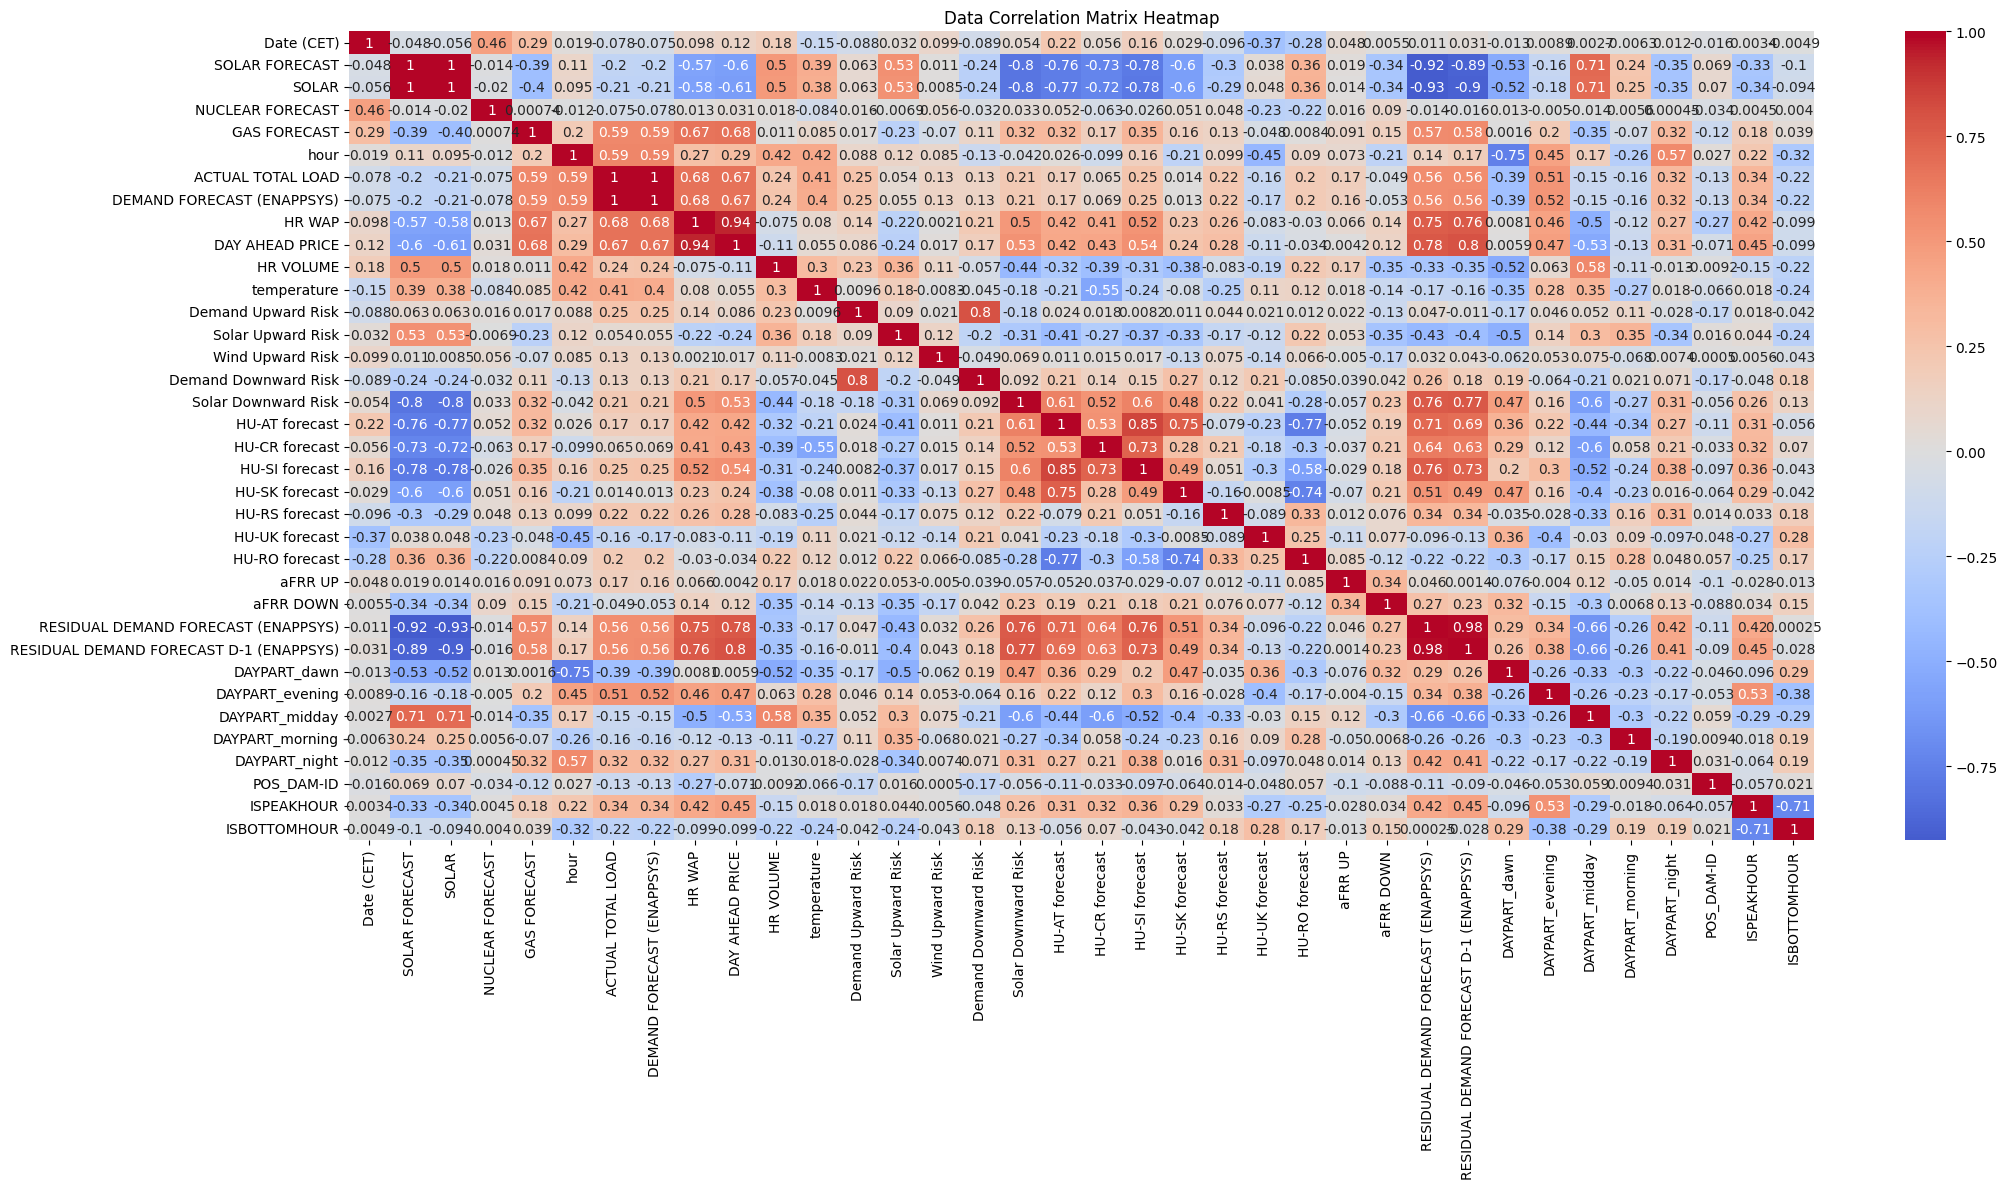

In [ ]:
plt.figure(figsize=(22, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Data Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

### Pozitív-e a DAM IDM különbsége? -> Klasszifikációs modell

In [ ]:
data['POS_DAM-ID'].value_counts()

,count
POS_DAM-ID,
0,581
1,546


In [ ]:
data.columns

Index(['Date (CET)', 'SOLAR FORECAST', 'SOLAR', 'NUCLEAR FORECAST',
       'GAS FORECAST', 'hour', 'ACTUAL TOTAL LOAD',
       'DEMAND FORECAST (ENAPPSYS)', 'HR WAP', 'DAY AHEAD PRICE', 'HR VOLUME',
       'temperature', 'Demand Upward Risk', 'Solar Upward Risk',
       'Wind Upward Risk', 'Demand Downward Risk', 'Solar Downward Risk',
       'HU-AT forecast', 'HU-CR forecast', 'HU-SI forecast', 'HU-SK forecast',
       'HU-RS forecast', 'HU-UK forecast', 'HU-RO forecast', 'aFRR UP',
       'aFRR DOWN', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)',
       'RESIDUAL DEMAND FORECAST D-1 (ENAPPSYS)', 'DAYPART_dawn',
       'DAYPART_evening', 'DAYPART_midday', 'DAYPART_morning', 'DAYPART_night',
       'POS_DAM-ID'],
      dtype='object')

In [ ]:
features = ['SOLAR FORECAST', 'GAS FORECAST', 'NUCLEAR FORECAST', 'temperature', 'DAYPART_dawn', 'DAYPART_evening', 'DAYPART_midday', 'DAYPART_morning', 'DAYPART_night', 'DEMAND FORECAST (ENAPPSYS)', 'DAY AHEAD PRICE', 'aFRR UP',
       'aFRR DOWN', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)', 'Demand Upward Risk', 'Demand Downward Risk', 'HU-AT forecast', 'HU-CR forecast', 'HU-SK forecast',
       'HU-RS forecast', 'HU-RO forecast', 'HR VOLUME', 'ISPEAKHOUR', 'ISBOTTOMHOUR']
target = 'POS_DAM-ID'

x = data[features]
y = data[target]

split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

accuracy = (y_pred == y_test).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 47.35%


In [ ]:
matches = y_test[y_test == y_pred]
mismatches = y_test[y_test != y_pred]

In [ ]:
print(round(len(matches)/len(y_test), 2) * 100)
print(round(len(mismatches)/len(y_test), 2) * 100)

print(matches.value_counts())
print(mismatches.value_counts())

47.0
53.0
POS_DAM-ID
0    70
1    37
Name: count, dtype: int64
POS_DAM-ID
1    77
0    42
Name: count, dtype: int64


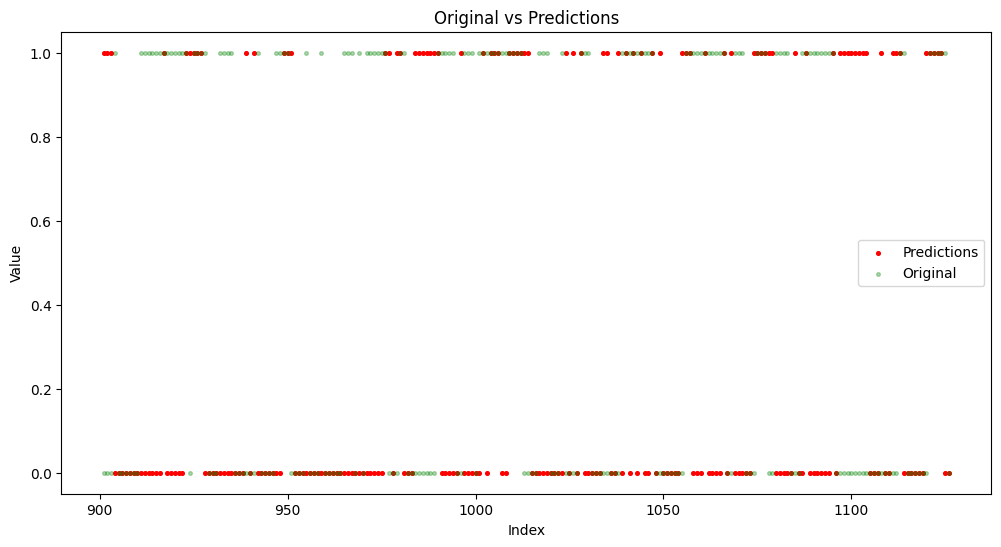

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_pred, label='Predictions', color='red', s=7)
plt.scatter(y_test.index, y_test, label='Original', color='green', alpha=0.3, s=7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original vs Predictions')
plt.legend()
plt.show()

### RandomForestClassifier-rel nő/nem nő

In [ ]:
from sklearn.ensemble import RandomForestClassifier

features =  ['SOLAR FORECAST', 'GAS FORECAST', 'NUCLEAR FORECAST', 'temperature', 'DAYPART_dawn', 'DAYPART_evening', 'DAYPART_midday', 'DAYPART_morning', 'DAYPART_night', 'DEMAND FORECAST (ENAPPSYS)', 'DAY AHEAD PRICE', 'aFRR UP',
       'aFRR DOWN', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)', 'Demand Upward Risk', 'Demand Downward Risk', 'HU-AT forecast', 'HU-CR forecast', 'HU-SK forecast',
       'HU-RS forecast', 'HU-RO forecast', 'HR VOLUME', 'ISPEAKHOUR', 'ISBOTTOMHOUR']
target = 'POS_DAM-ID'

x = data[features]
y = data[target]

split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

rdf_model = RandomForestClassifier(random_state=42)
rdf_model.fit(x_train, y_train)

y_pred = rdf_model.predict(x_test)

accuracy = (y_pred == y_test).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 46.90%


### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
features =  ['SOLAR FORECAST', 'GAS FORECAST', 'NUCLEAR FORECAST', 'temperature', 'DAYPART_dawn', 'DAYPART_evening', 'DAYPART_midday', 'DAYPART_morning', 'DAYPART_night', 'DEMAND FORECAST (ENAPPSYS)', 'DAY AHEAD PRICE', 'aFRR UP',
       'aFRR DOWN', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)', 'Demand Upward Risk', 'Demand Downward Risk', 'HU-AT forecast', 'HU-CR forecast', 'HU-SK forecast',
       'HU-RS forecast', 'HU-RO forecast', 'HR VOLUME', 'ISPEAKHOUR', 'ISBOTTOMHOUR']
target = 'POS_DAM-ID'

x = data[features]
y = data[target]

split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

svc_model = SVC(random_state=42)
svc_model.fit(x_train, y_train)

y_pred = svc_model.predict(x_test)

accuracy = (y_pred == y_test).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 53.98%


### HR WAP predikció

In [ ]:
data['DAYOFWEEK'] = data['Date (CET)'].dt.dayofweek
data['ISWEEKEND'] = data['DAYOFWEEK'].apply(lambda x: 1 if x >= 5 else 0)
data['NET_FORECAST_IMP_EXPORTS'] = data['HU-AT forecast'] + data['HU-CR forecast'] + data['HU-SI forecast'] + data['HU-SK forecast'] + data['HU-RS forecast'] + data['HU-UK forecast'] + data['HU-RO forecast']

In [ ]:
over_30 = data.loc[data['temp'] ]
data['ISCOOLING'].apply()

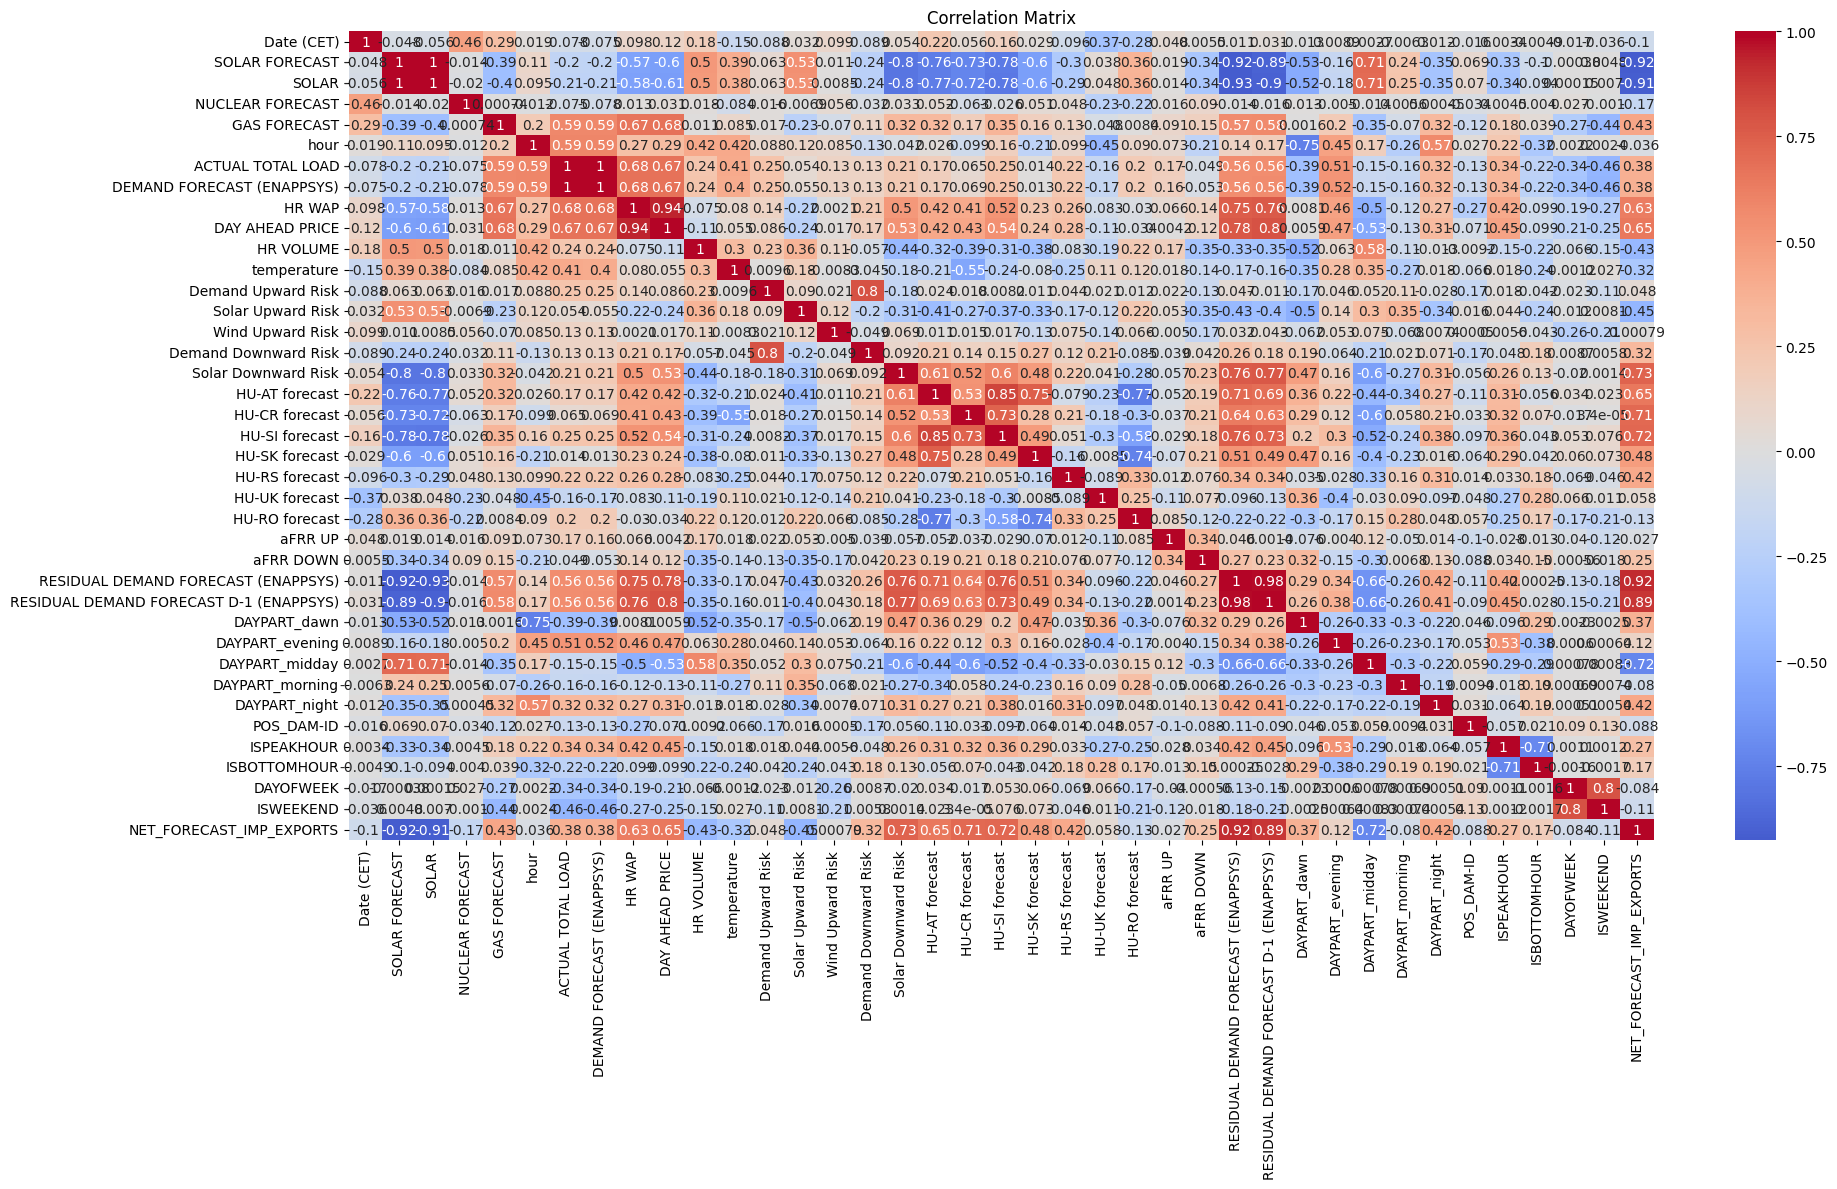

In [ ]:
plt.figure(figsize =(20, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
crossborder.columns

Index(['Date (CET)', 'HU-AT forecast', 'HU-CR forecast', 'HU-SI forecast',
       'HU-SK forecast', 'HU-RS forecast', 'HU-UK forecast', 'HU-RO forecast',
       'hour'],
      dtype='object')

In [ ]:
risks.columns

Index(['Date (CET)', 'Demand Upward Risk', 'Solar Upward Risk',
       'Wind Upward Risk', 'Demand Downward Risk', 'Solar Downward Risk',
       'hour'],
      dtype='object')

In [ ]:
hourly_dic = {}
for name, df in hourly_dic.items():
  print(name, df['DEMAND FORECAST (ENAPPSYS)'].mean())

### XGBoost Regression

Mean Absolute Error: 19.668453479361744
R-squared: 0.7661678537182155


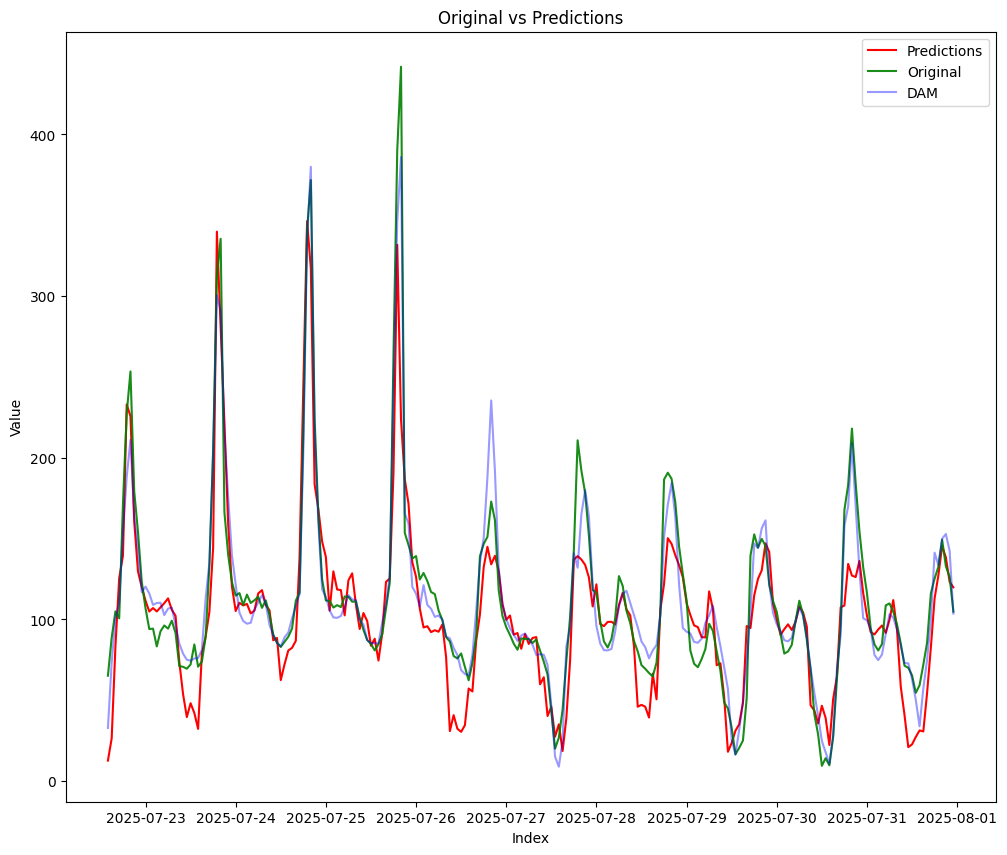

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

feat = ['SOLAR FORECAST', 'GAS FORECAST', 'DEMAND FORECAST (ENAPPSYS)', 'temperature', 'DAYPART_evening', 'DAYPART_midday', 'DAYPART_night', 'ISWEEKEND', 'hour', 'HU-AT forecast', 'HU-CR forecast',
       'HU-SK forecast', 'HU-RS forecast', 'HU-RO forecast', 'Demand Upward Risk', 'Solar Upward Risk', 'Wind Upward Risk', 'Demand Downward Risk', 'ISPEAKHOUR', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)', 'HR VOLUME', 'aFRR UP', 'aFRR DOWN']
target = 'HR WAP'
x = data[feat]
y = data[target]

split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

xgb_reg_model = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42)
xgb_reg_model.fit(x_train, y_train)
y_pred1 = xgb_reg_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

plt.figure(figsize=(12, 10))
plt.plot(data['Date (CET)'].iloc[y_test.index], y_pred1, label='Predictions', color='red')
plt.plot(data['Date (CET)'].iloc[y_test.index], y_test, label='Original', color='green', alpha=0.9)
plt.plot(data['Date (CET)'].iloc[y_test.index], data['DAY AHEAD PRICE'].iloc[y_test.index], label='DAM', color='blue', alpha=0.4)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original vs Predictions')
plt.legend()
plt.show()

In [ ]:
joblib.dump(xgb_reg_model, 'xgb_reg_model.pkl')

['xgb_reg_model.pkl']

### RandomForestRegression

Mean Absolute Error: 22.19453960176991
R-squared: 0.6226164035840278


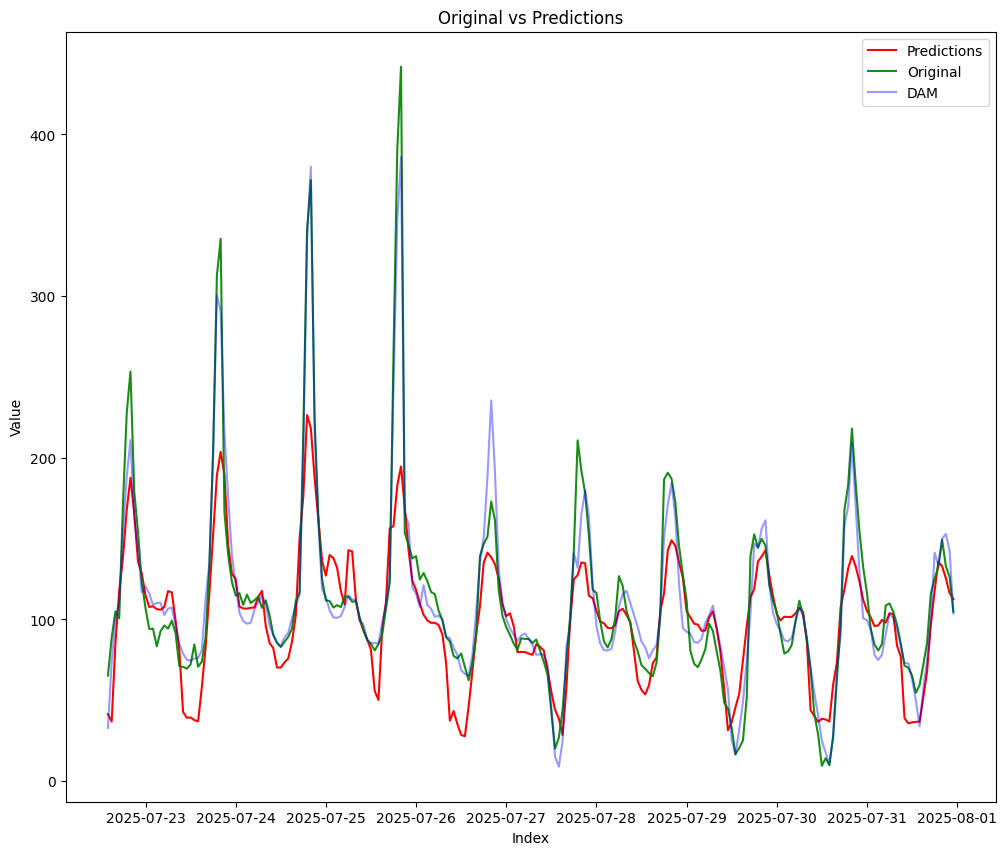

In [ ]:
feat = ['SOLAR FORECAST', 'GAS FORECAST', 'DEMAND FORECAST (ENAPPSYS)', 'temperature', 'DAYPART_evening', 'DAYPART_midday', 'DAYPART_night', 'ISWEEKEND', 'hour', 'HU-AT forecast', 'HU-CR forecast',
       'HU-SK forecast', 'HU-RS forecast', 'HU-RO forecast', 'Demand Upward Risk', 'Solar Upward Risk', 'Wind Upward Risk', 'Demand Downward Risk', 'ISPEAKHOUR', 'ISBOTTOMHOUR', 'RESIDUAL DEMAND FORECAST (ENAPPSYS)', 'HR VOLUME', 'aFRR UP', 'aFRR DOWN']
target = 'HR WAP'
x = data[feat]
y = data[target]

split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(x_train, y_train)
y_pred2 = rf_model.predict(x_test)

mae2 = mean_absolute_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)

print(f'Mean Absolute Error: {mae2}')
print(f'R-squared: {r2_2}')

plt.figure(figsize=(12, 10))
plt.plot(data['Date (CET)'].iloc[y_test.index], y_pred2, label='Predictions', color='red')
plt.plot(data['Date (CET)'].iloc[y_test.index], y_test, label='Original', color='green', alpha=0.9)
plt.plot(data['Date (CET)'].iloc[y_test.index], data['DAY AHEAD PRICE'].iloc[y_test.index], label='DAM', color='blue', alpha=0.4)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original vs Predictions')
plt.legend()
plt.show()

In [ ]:
hourly_dic = {}
for hour in range(24):
  hourly_dic[hour] = data[data['hour'] == hour]

In [ ]:
hourly_dic[0]

,Date (CET),SOLAR FORECAST,SOLAR,NUCLEAR FORECAST,GAS FORECAST,hour,ACTUAL TOTAL LOAD,DEMAND FORECAST (ENAPPSYS),HR WAP,DAY AHEAD PRICE,...,RELEVANT GENERATION FORECAST,DAYPART_dawn,DAYPART_evening,DAYPART_midday,DAYPART_morning,DAYPART_night,POS_DAM-ID,DAYOFWEEK,ISWEEKEND,ISPEAKHOUR
23,2025-06-16,0.0,0.0,1402.0,280.0,0,4055.0,4053.0,100.14,104.18,...,1682.0,1,0,0,0,0,1,0,0,0
47,2025-06-17,0.0,0.0,1402.0,523.0,0,4500.0,4512.0,98.15,104.77,...,1925.0,1,0,0,0,0,1,1,0,0
71,2025-06-18,0.0,0.0,1404.0,559.0,0,4521.0,4518.0,112.65,112.84,...,1963.0,1,0,0,0,0,1,2,0,0
95,2025-06-19,0.0,1.0,1399.0,548.0,0,4720.0,4738.0,125.05,113.53,...,1947.0,1,0,0,0,0,0,3,0,0
119,2025-06-20,0.0,0.0,1395.0,550.0,0,4733.0,4740.0,134.45,114.16,...,1945.0,1,0,0,0,0,0,4,0,0
143,2025-06-21,0.0,1.0,1399.0,551.0,0,4487.0,4493.0,117.80,119.21,...,1950.0,1,0,0,0,0,1,5,1,0
167,2025-06-22,0.0,0.0,1401.0,502.0,0,4018.0,4028.0,105.66,108.92,...,1903.0,1,0,0,0,0,1,6,1,0
191,2025-06-23,0.0,0.0,1401.0,388.0,0,4060.0,4065.0,93.92,85.86,...,1789.0,1,0,0,0,0,0,0,0,0
215,2025-06-24,0.0,0.0,1398.0,493.0,0,4726.0,4742.0,115.20,104.08,...,1891.0,1,0,0,0,0,0,1,0,0
239,2025-06-25,0.0,0.0,1391.0,892.0,0,4832.0,4833.0,143.75,127.56,...,2283.0,1,0,0,0,0,0,2,0,0
